In [99]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os

from tensorflow.keras import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dropout
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.optimizers import Adam

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
os.chdir('/Users/renatoboemer/code/lewagon/jet-engine/raw_data/Cmaps')

In [3]:
txt_files = [f for f in os.listdir() if f.endswith('.txt') and 'train' in f]

In [4]:
dataframes = {}

for file in txt_files:
    df = pd.read_csv(file, header=None, sep=" ")  # Adjust the delimiter if it's not a comma.
    
    # Use the filename without the extension as the key
    key_name = os.path.splitext(file)[0]
    dataframes[key_name] = df

In [5]:
dataframes['train_FD001'][:5]

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [6]:
index_names = ['Engine', 'Cycle']
setting_names = ['Setting 1', 'Setting 2', 'Setting 3']
sensor_names=[ "(Fan Inlet Temperature) (◦R)",
               "(LPC Outlet Temperature) (◦R)",
               "(HPC Outlet Temperature) (◦R)",
               "(LPT Outlet Temperature) (◦R)",
               "(Fan Inlet Pressure) (psia)",
               "(Bypass-Duct Pressure) (psia)",
               "(HPC Outlet Pressure) (psia)",
               "(Physical Fan Speed) (rpm)",
               "(Physical Core Speed) (rpm)",
               "(Engine Pressure Ratio(P50/P2)",
               "(HPC Outlet Static Pressure) (psia)",
               "(Ratio of Fuel Flow to Ps30) (pps/psia)",
               "(Corrected Fan Speed) (rpm)",
               "(Corrected Core Speed) (rpm)",
               "(Bypass Ratio) ",
               "(Burner Fuel-Air Ratio)",
               "(Bleed Enthalpy)",
               "(Required Fan Speed)",
               "(Required Fan Conversion Speed)",
               "(High-Pressure Turbines Cool Air Flow)",
               "(Low-Pressure Turbines Cool Air Flow)",
               "Sensor 26",
               "Sensor 27"]

col_names = index_names + setting_names + sensor_names

## FD001 dataset

FD001 subset corresponds to High-Pressure Compressor (HPC) failure of the engine.

The dataset FD001 contains time series of 21 sensors and 3 settings of 100 units(turbofan engine). Each engine works normally at the beginning of each time series and fails at the end of the time series. Each row is a snapshot of the data taken during a single operation cycle.

In [7]:
df_train_FD001 = dataframes['train_FD001']
df_train_FD001.columns = col_names

In [8]:
df_train_FD001.shape

(20631, 28)

In [9]:
df_train_FD001.describe().T

,count,mean,std,min,25%,50%,75%,max
Engine,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
Cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
Setting 1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
Setting 2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
Setting 3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
(Fan Inlet Temperature) (◦R),20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
(LPC Outlet Temperature) (◦R),20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
(HPC Outlet Temperature) (◦R),20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
(LPT Outlet Temperature) (◦R),20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
(Fan Inlet Pressure) (psia),20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200


In [10]:
df_train_FD001 = df_train_FD001.drop(columns=['Sensor 26', 'Sensor 27'])

In [11]:
df_train_FD001.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Engine                                   20631 non-null  int64  
 1   Cycle                                    20631 non-null  int64  
 2   Setting 1                                20631 non-null  float64
 3   Setting 2                                20631 non-null  float64
 4   Setting 3                                20631 non-null  float64
 5   (Fan Inlet Temperature) (◦R)             20631 non-null  float64
 6   (LPC Outlet Temperature) (◦R)            20631 non-null  float64
 7   (HPC Outlet Temperature) (◦R)            20631 non-null  float64
 8   (LPT Outlet Temperature) (◦R)            20631 non-null  float64
 9   (Fan Inlet Pressure) (psia)              20631 non-null  float64
 10  (Bypass-Duct Pressure) (psia)            20631

In [12]:
df_train_FD001.head()

,Engine,Cycle,Setting 1,Setting 2,Setting 3,(Fan Inlet Temperature) (◦R),(LPC Outlet Temperature) (◦R),(HPC Outlet Temperature) (◦R),(LPT Outlet Temperature) (◦R),(Fan Inlet Pressure) (psia),...,(Ratio of Fuel Flow to Ps30) (pps/psia),(Corrected Fan Speed) (rpm),(Corrected Core Speed) (rpm),(Bypass Ratio),(Burner Fuel-Air Ratio),(Bleed Enthalpy),(Required Fan Speed),(Required Fan Conversion Speed),(High-Pressure Turbines Cool Air Flow),(Low-Pressure Turbines Cool Air Flow)
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [13]:
df_train_FD001.columns

Index(['Engine', 'Cycle', 'Setting 1', 'Setting 2', 'Setting 3',
       '(Fan Inlet Temperature) (◦R)', '(LPC Outlet Temperature) (◦R)',
       '(HPC Outlet Temperature) (◦R)', '(LPT Outlet Temperature) (◦R)',
       '(Fan Inlet Pressure) (psia)', '(Bypass-Duct Pressure) (psia)',
       '(HPC Outlet Pressure) (psia)', '(Physical Fan Speed) (rpm)',
       '(Physical Core Speed) (rpm)', '(Engine Pressure Ratio(P50/P2)',
       '(HPC Outlet Static Pressure) (psia)',
       '(Ratio of Fuel Flow to Ps30) (pps/psia)',
       '(Corrected Fan Speed) (rpm)', '(Corrected Core Speed) (rpm)',
       '(Bypass Ratio) ', '(Burner Fuel-Air Ratio)', '(Bleed Enthalpy)',
       '(Required Fan Speed)', '(Required Fan Conversion Speed)',
       '(High-Pressure Turbines Cool Air Flow)',
       '(Low-Pressure Turbines Cool Air Flow)'],
      dtype='object')

In [14]:
round(df_train_FD001.loc[:,['Engine', 'Cycle']].describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
Engine,20631.0,51.51,29.23,1.0,26.0,52.0,77.0,100.0
Cycle,20631.0,108.81,68.88,1.0,52.0,104.0,156.0,362.0


In [15]:
max_cycles = df_train_FD001.groupby('Engine')['Cycle'].max()

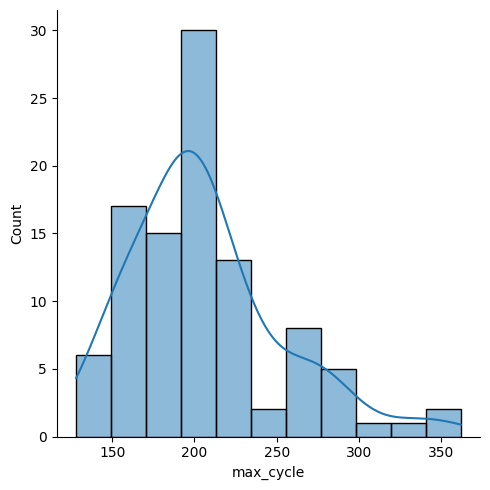

In [16]:
# Distribution of maximum cycles
sns.displot(max_cycles, kde=True, bins='fd')
plt.xlabel('max_cycle');

To determine the number of bins, I have applied the Freedman-Diaconis Rule ('fd'). It utilises the interquartile range of the data and the number of data points to balance histogram detail and readability, thereby aiding in the accurate representation and interpretation of the underlying data distribution.

It seems that most engines have an average of ~200 cycles before HPC failure. Only a few can go up to 350 cycle.

# RUL column (target)

The Remaining Useful Life (RUL) corresponds to the remaining cycles for each unit before the engine fails. This is the target our model will attempt to predict.

In [17]:
def add_RUL_column(df):
    # Calculate max_Cycles
    max_Cycles = df.groupby('Engine')['Cycle'].max()
    
    # Merge with the original DataFrame
    merged = df.merge(max_Cycles.to_frame(name='max_Cycle'), left_on='Engine', right_index=True)
    
    # Calculate RUL
    merged['RUL'] = merged['max_Cycle'] - merged['Cycle']
    
    # Drop the max_Cycle column
    merged = merged.drop('max_Cycle', axis=1)
    
    return merged


In [18]:
df = add_RUL_column(df_train_FD001)

In [19]:
df.head()

,Engine,Cycle,Setting 1,Setting 2,Setting 3,(Fan Inlet Temperature) (◦R),(LPC Outlet Temperature) (◦R),(HPC Outlet Temperature) (◦R),(LPT Outlet Temperature) (◦R),(Fan Inlet Pressure) (psia),...,(Corrected Fan Speed) (rpm),(Corrected Core Speed) (rpm),(Bypass Ratio),(Burner Fuel-Air Ratio),(Bleed Enthalpy),(Required Fan Speed),(Required Fan Conversion Speed),(High-Pressure Turbines Cool Air Flow),(Low-Pressure Turbines Cool Air Flow),RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [20]:
df[['Engine','RUL']][:10]

,Engine,RUL
0,1,191
1,1,190
2,1,189
3,1,188
4,1,187
5,1,186
6,1,185
7,1,184
8,1,183
9,1,182


## Correlation

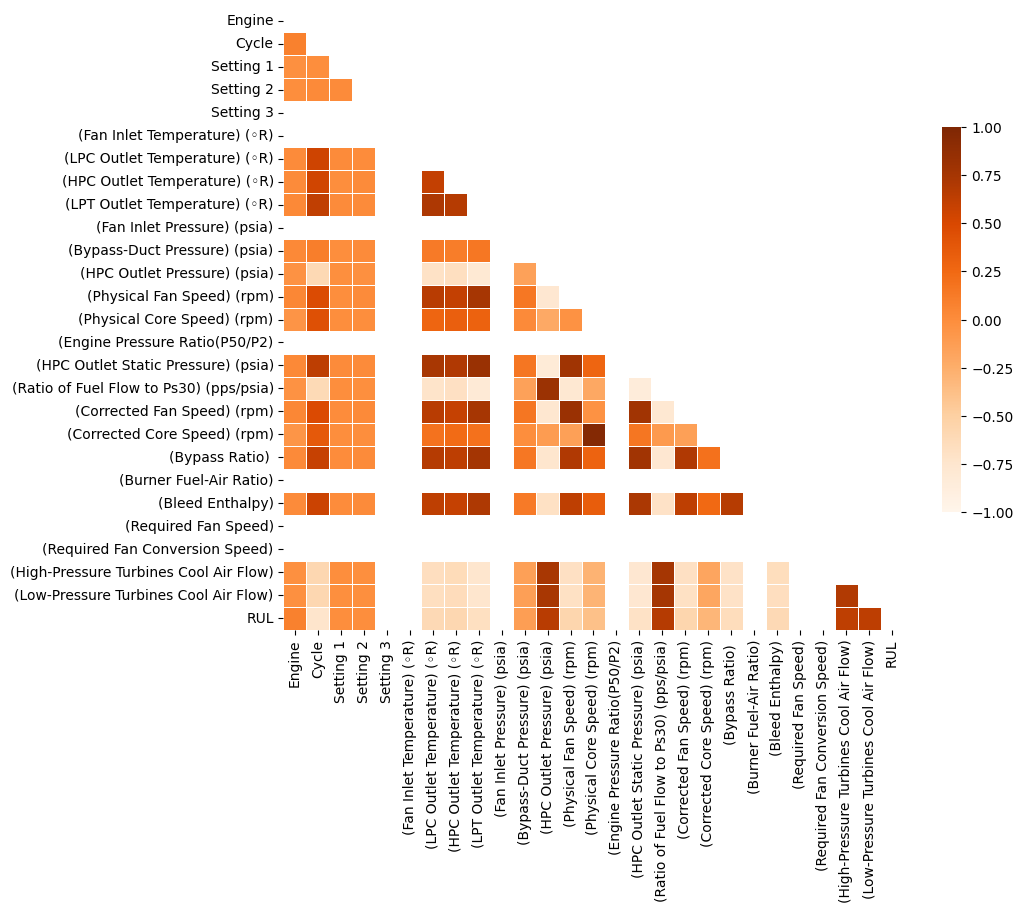

In [21]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.color_palette('Oranges', as_cmap=True)

# Plot heatmap
sns.heatmap(corr, 
            mask=mask, 
            cmap=cmap, 
            vmax=1,
            vmin=-1,
            center=0, 
            square=True, 
            linewidths=0.5, 
            cbar_kws={'shrink':0.5});

Let's delve into potential correlations based on the physics and operation of such systems:

**Temperature Features**:

- Fan inlet temperature (°R): The temperature of air entering the fan.
- LPC outlet temperature (°R): Temperature after the low-pressure compressor (LPC).
- HPC outlet temperature (°R): Temperature after the high-pressure compressor (HPC).
- LPT outlet temperature (°R): Temperature after the low-pressure turbine (LPT).

Based on the thermodynamic cycle of a jet engine, we can anticipate the correlations between these temperature readings. For instance, if the fan inlet temperature increases, it may cause corresponding increases in the temperatures after the compressors and turbines. However, other factors like the efficiency of the compressors and turbines can play a role. Among these, HPC outlet temperature and LPT outlet temperature are usually strongly correlated, especially if the efficiency of the HPC affects the LPT directly.

**Pressure Features**:

- Fan inlet Pressure (psia): Pressure of air entering the fan.
- Bypass-duct pressure (psia): Pressure in the bypass duct of a turbofan.
- HPC outlet pressure (psia): Pressure after the high-pressure compressor.
- HPC outlet Static pressure (psia): Static pressure after the high-pressure compressor.

Typically, HPC outlet pressure and HPC outlet Static pressure describe pressures at the HPC outlet, just from different perspectives (total vs static). From a physics perspective, the difference between these two pressures is that the HPC outlet pressure usually refers to the total pressure (which includes both static and dynamic pressure components), while the HPC outlet static pressure only accounts for the static component. The dynamic pressure is associated with the velocity of the flow. In scenarios where the velocity (and hence dynamic pressure) is not significantly varying, the difference between these two might be minimal. So, we might consider dropping one of these feature after analysing their importance to the model.

**Speed Features**:

- Physical fan speed (rpm)
- Physical core speed (rpm)
- Corrected fan speed (rpm)
- Corrected core speed (rpm)

The physical and corrected speeds for the same component (fan or core) are likely to be correlated. Corrected speed is generally the physical speed adjusted for ambient conditions. Depending on the use case, you might choose to use either the physical or corrected speed but might not need both.

**Other Features**:

Features like Engine pressure ratio (P50/P2), which represents a ratio of pressures, might also be correlated with individual pressure readings. This would need to be verified with data.
Cool Air Flow Features:

High-pressure turbines Cool air flow
Low-pressure turbines Cool air flow
Depending on the design and operation of the engine, these could be correlated, especially if cooling air flows are linked or if they are affected by similar operational conditions.

In [22]:
def plot_signal(df, col, rolling_window=10, figsize=(10,4), xlim=(250, 0), xticks=np.arange(0, 300, 25)):
    """
    Plots the rolling mean of a signal against the RUL for specified Engine.
    
    Parameters:
    - df: DataFrame containing the data
    - col: Name of the signal to be plotted (column name)
    - rolling_window: Size of the rolling window for mean calculation. Default is 10.
    """
    
    # Error handling
    if col not in df.columns:
        raise ValueError(f"'{col}' not found in the DataFrame columns.")
    
    # Plot initialization
    plt.figure(figsize=figsize)
    
    # Loop through unit numbers and plot
    for i in df['Engine'].unique():
        if (i % 10 == 0):
            plt.plot('RUL', col, data=df[df['Engine'] == i].rolling(rolling_window).mean(), label=f"Unit {i}")

    # Formatting
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.ylabel(col)
    plt.xlabel('Remaining Useful Life')
    plt.legend(loc='upper left')
    
    # Display
    plt.show()


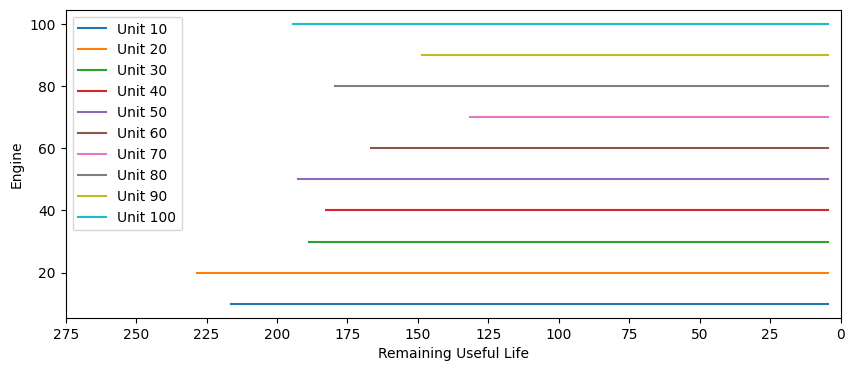

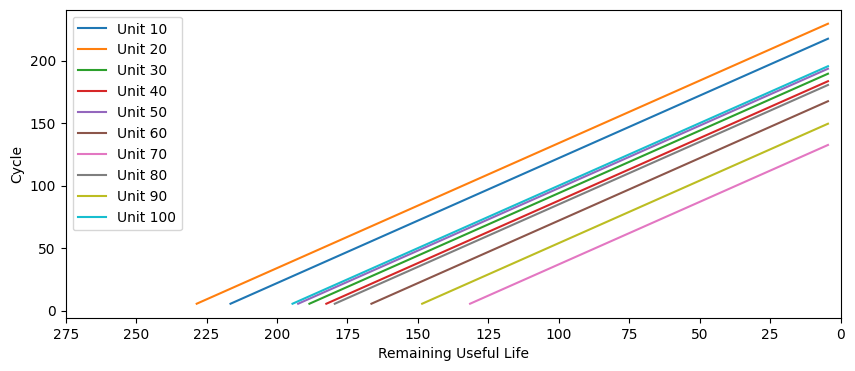

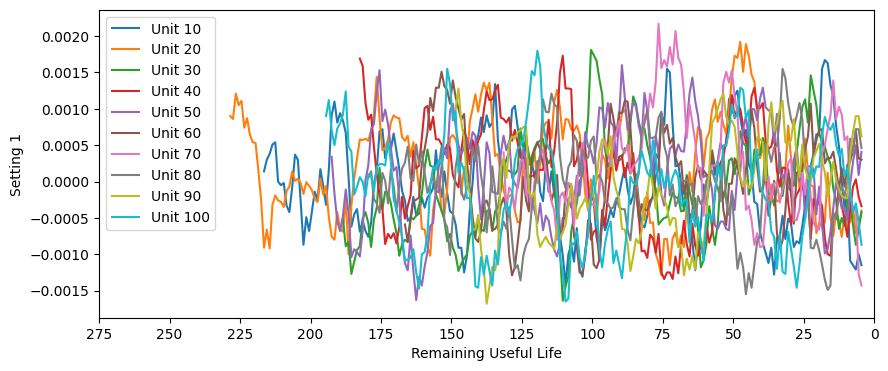

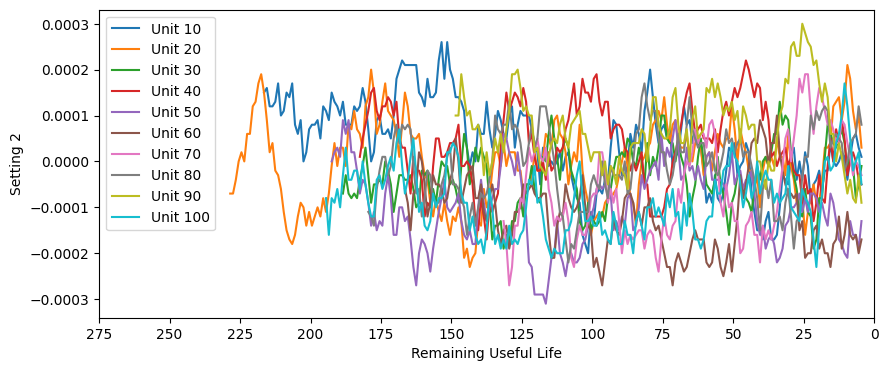

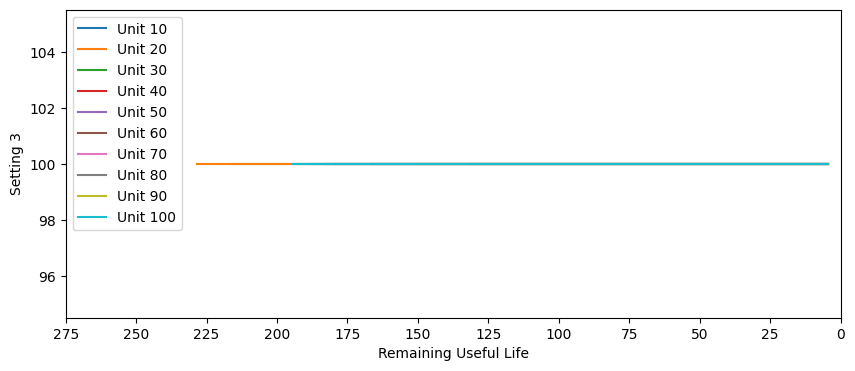

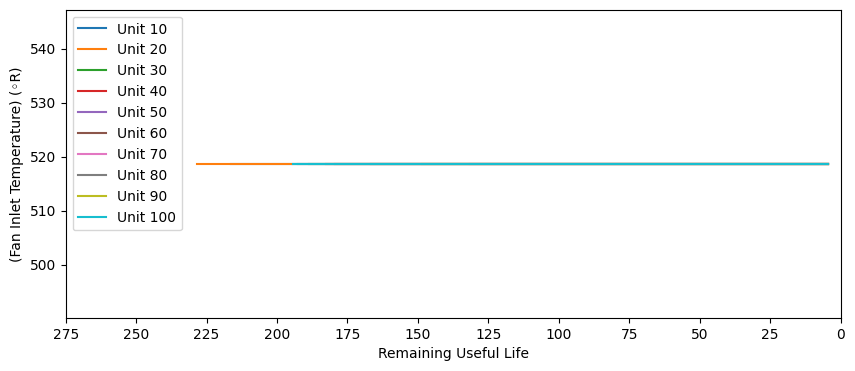

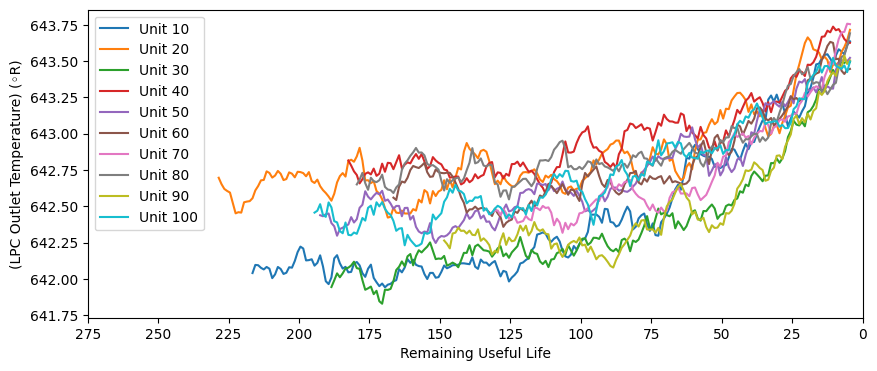

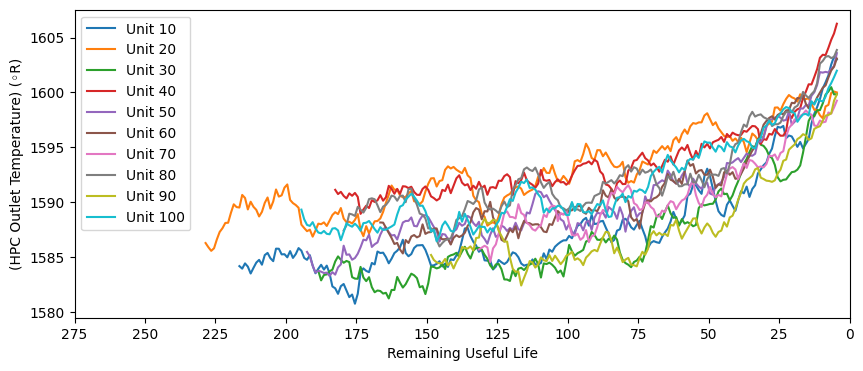

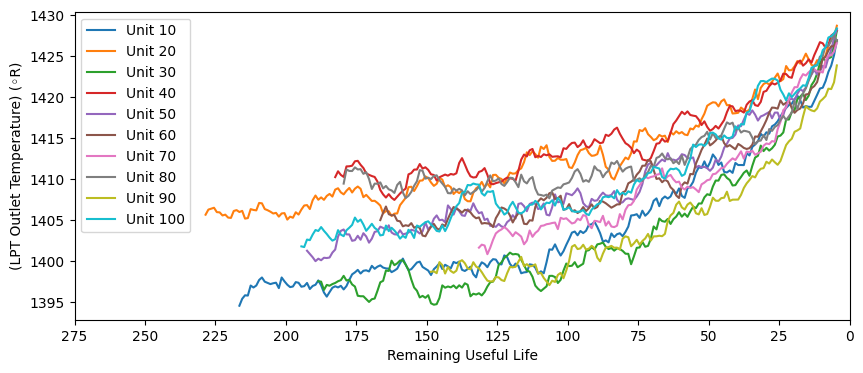

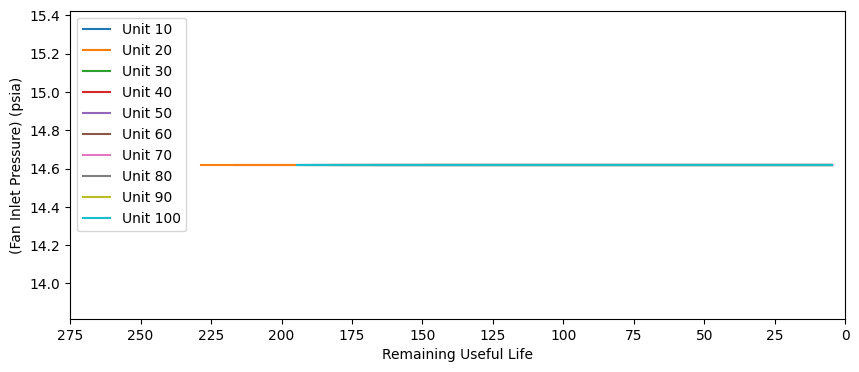

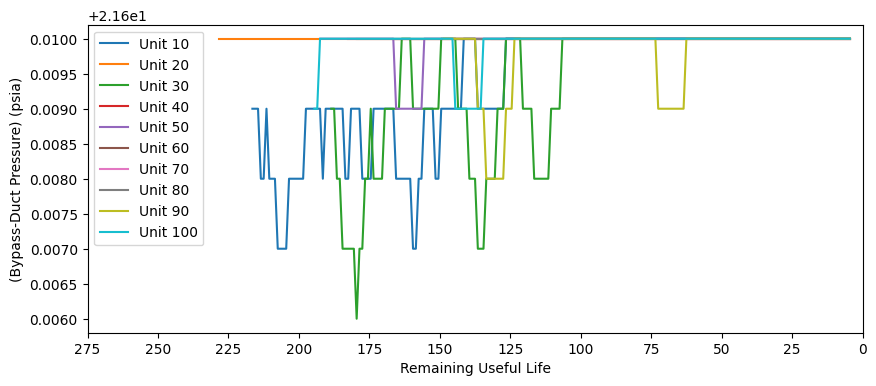

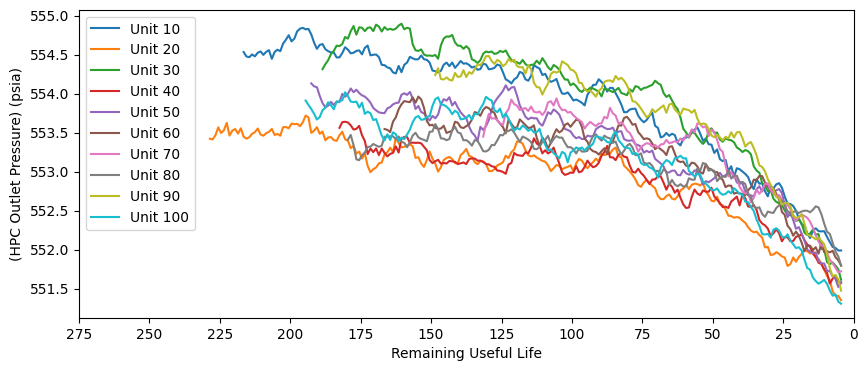

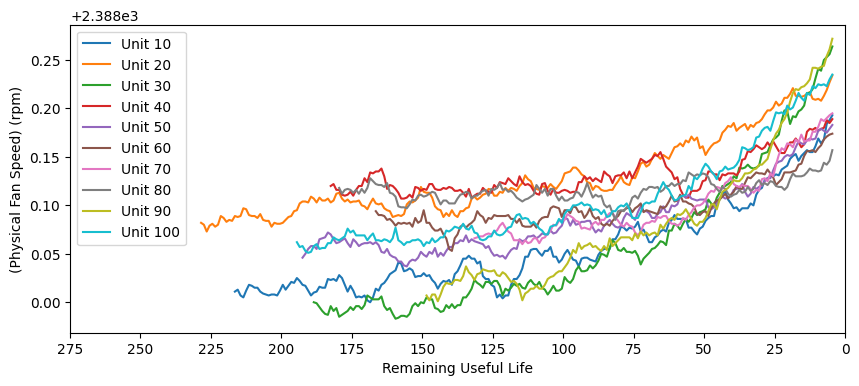

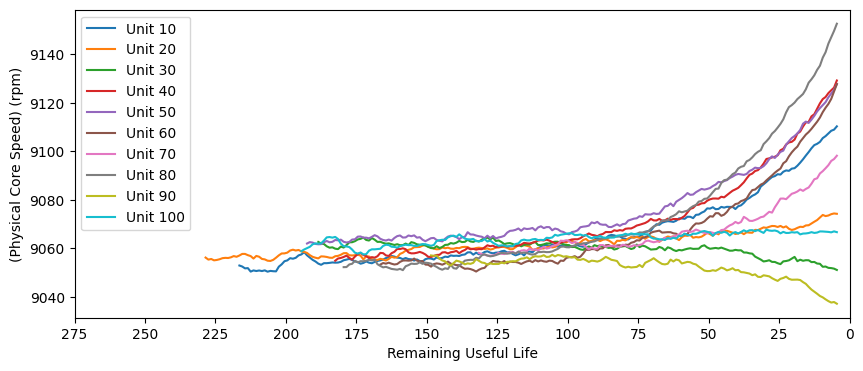

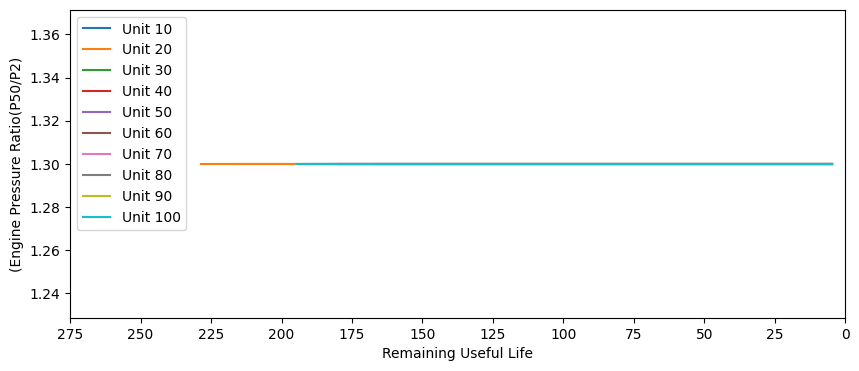

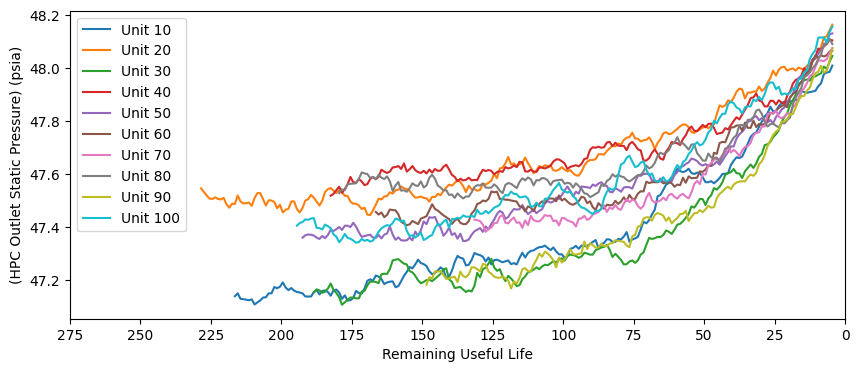

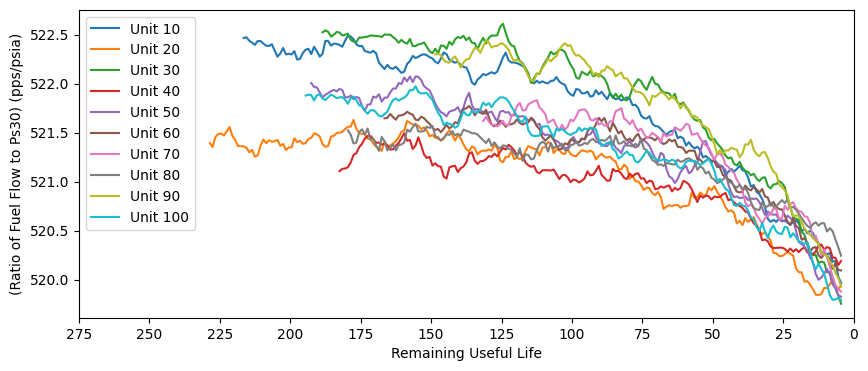

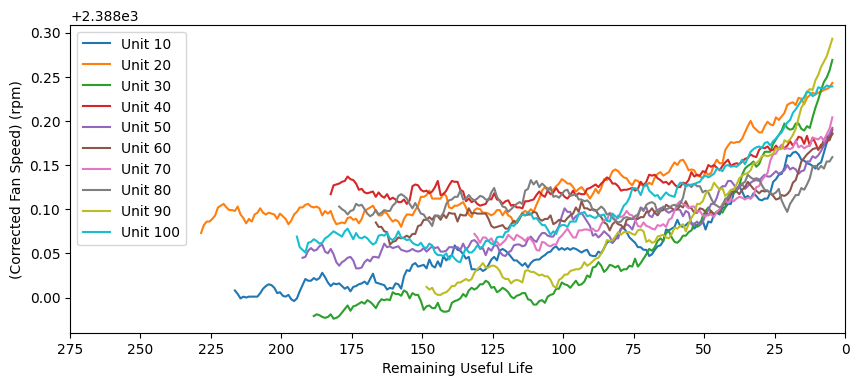

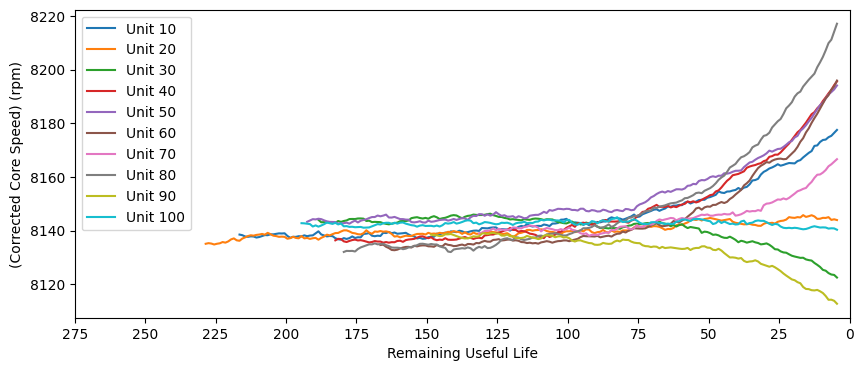

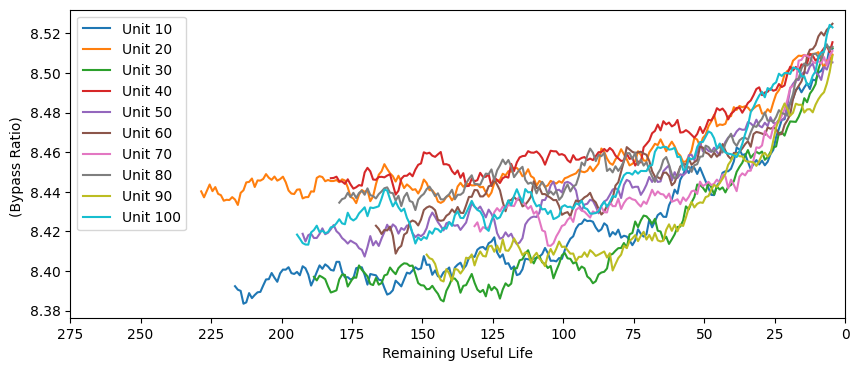

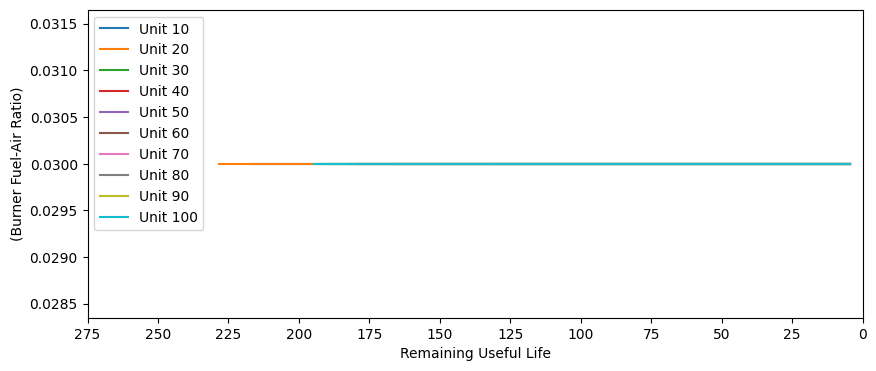

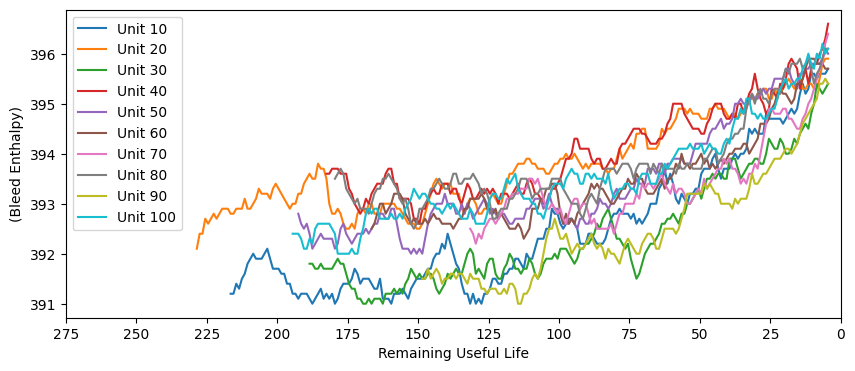

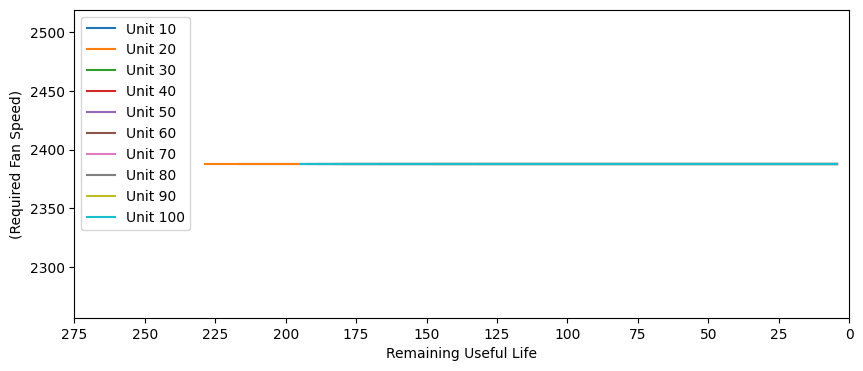

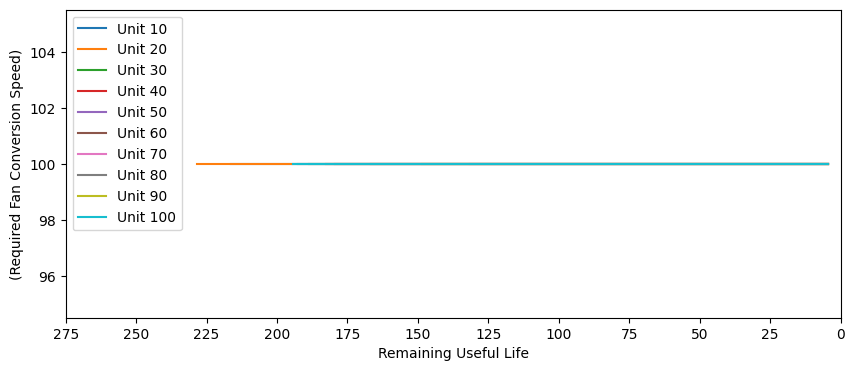

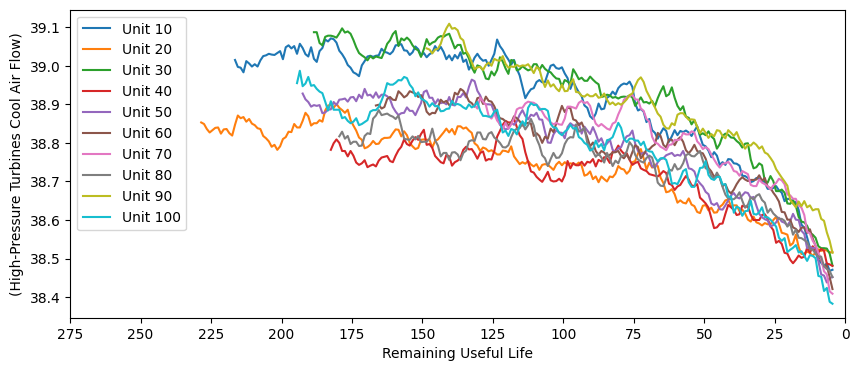

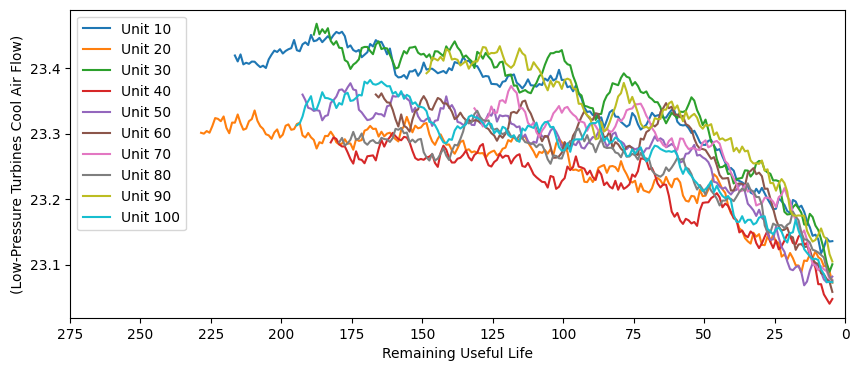

In [23]:
exclude_columns = ['unit_number', 'RUL']

# Loop through each column in the dataframe
for col in df.columns:
    if col not in exclude_columns:
        plot_signal(df, col)

Let's drop features that show a constant value. It suggests there is not change as the RUL reaches failure.
We will also drop Setting 1, 2, and 3 which show opposite behaviour and no correlation with RUL.

In [24]:
df.columns

Index(['Engine', 'Cycle', 'Setting 1', 'Setting 2', 'Setting 3',
       '(Fan Inlet Temperature) (◦R)', '(LPC Outlet Temperature) (◦R)',
       '(HPC Outlet Temperature) (◦R)', '(LPT Outlet Temperature) (◦R)',
       '(Fan Inlet Pressure) (psia)', '(Bypass-Duct Pressure) (psia)',
       '(HPC Outlet Pressure) (psia)', '(Physical Fan Speed) (rpm)',
       '(Physical Core Speed) (rpm)', '(Engine Pressure Ratio(P50/P2)',
       '(HPC Outlet Static Pressure) (psia)',
       '(Ratio of Fuel Flow to Ps30) (pps/psia)',
       '(Corrected Fan Speed) (rpm)', '(Corrected Core Speed) (rpm)',
       '(Bypass Ratio) ', '(Burner Fuel-Air Ratio)', '(Bleed Enthalpy)',
       '(Required Fan Speed)', '(Required Fan Conversion Speed)',
       '(High-Pressure Turbines Cool Air Flow)',
       '(Low-Pressure Turbines Cool Air Flow)', 'RUL'],
      dtype='object')

In [25]:
df = df.drop(columns=['Setting 1', 'Setting 2', 'Setting 3', '(Fan Inlet Temperature) (◦R)', 
                      '(Fan Inlet Pressure) (psia)', '(Engine Pressure Ratio(P50/P2)',
                      '(Burner Fuel-Air Ratio)', '(Required Fan Speed)', '(Required Fan Conversion Speed)'])

In [26]:
df.head()

,Engine,Cycle,(LPC Outlet Temperature) (◦R),(HPC Outlet Temperature) (◦R),(LPT Outlet Temperature) (◦R),(Bypass-Duct Pressure) (psia),(HPC Outlet Pressure) (psia),(Physical Fan Speed) (rpm),(Physical Core Speed) (rpm),(HPC Outlet Static Pressure) (psia),(Ratio of Fuel Flow to Ps30) (pps/psia),(Corrected Fan Speed) (rpm),(Corrected Core Speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-Pressure Turbines Cool Air Flow),(Low-Pressure Turbines Cool Air Flow),RUL
0,1,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


## Feature Scaling

In [27]:
df.shape

(20631, 18)

In [28]:
# X = df.drop(columns=['Engine', 'RUL']).copy()

# y = df['RUL']

In [29]:
# Assuming df is sorted by 'Engine' and 'Cycle'
X_list = []
y_list = []

for engine, group in df.groupby('Engine'):
    X_values = group.drop(columns=['Engine', 'RUL']).values
    y_values = group['RUL'].iloc[-1]
    X_list.append(X_values)
    y_list.append(y_values)

In [38]:
from tensorflow.keras.utils import pad_sequences

X_padded = pad_sequences(X_list, dtype='float32', padding='post', value=0)
y = np.array(y_list)

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [123]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = np.array([scaler.fit_transform(x) for x in X_train])
X_test_scaled = np.array([scaler.transform(x) for x in X_test])

## Model

In [ ]:
# # learning rate scheduler
# def scheduler(epoch, lr):
#   if epoch >= 50:
#     return 0.0001
#   return 0.001

# # Create a learning rate scheduler callback
# lr_scheduler = LearningRateScheduler(scheduler)

In [124]:
def initialize_model():
    # RNN Architecture
    model = Sequential()
    
    # LSTM layer with L2 regularization
    model.add(layers.LSTM(units=30, 
                          activation='tanh',
                          kernel_regularizer=regularizers.l2(0.01),
                          input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    
    # Dropout layer to reduce overfitting
    model.add(Dropout(0.2))
    
    # Batch normalisation layer
    model.add(BatchNormalization())
    
    # Dense output layer
    model.add(layers.Dense(1, activation='linear'))

    # Compile
    model.compile(loss='mean_squared_error',
                  optimizer='rmsprop',
                  metrics=['mean_absolute_error'])

    return model

model = initialize_model()

In [125]:
# from tensorflow.keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss', 
#                            patience=10, 
#                            verbose=1, 
#                            restore_best_weights=True)

In [126]:
# 3- Model training
history = model.fit(X_train_scaled, y_train,
                    validation_data=(X_test_scaled, y_test),
                    epochs=100,
                    batch_size=160,
                    # callbacks=[early_stop],
                    verbose=0)

# # 4- Predict
# model.predict(X)

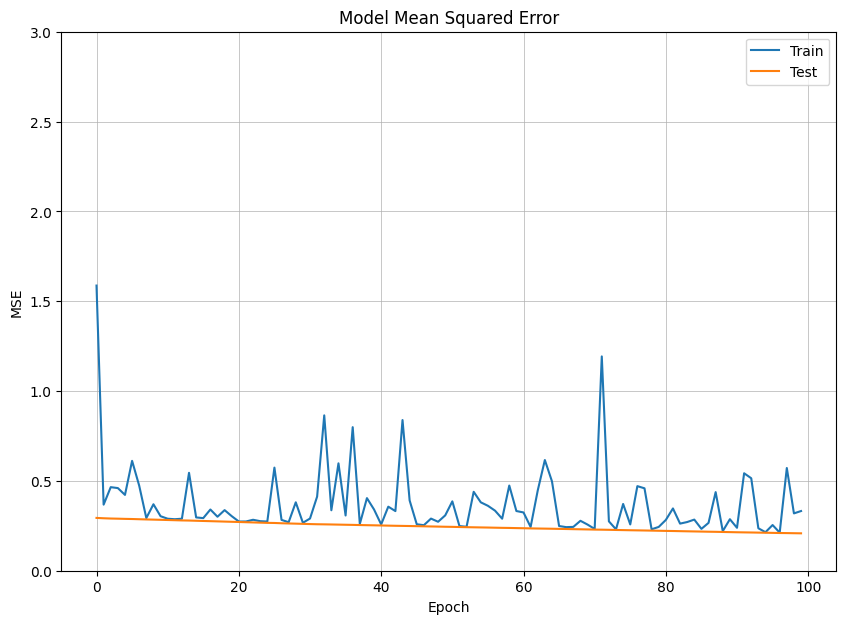

In [127]:
def plot_loss(history, title=None):
    fig, ax = plt.subplots(figsize=(10,7))

    # --- LOSS ---
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])

    ax.set_title('Model Mean Squared Error')
    ax.set_ylabel('MSE')
    ax.set_xlabel('Epoch')
    ax.set_ylim((0,3))

    ax.legend(['Train', 'Test'], loc='best')

    ax.grid(axis='x', linewidth=0.5)
    ax.grid(axis='y', linewidth=0.5)

    if title:
        plt.title(title)

    plt.show()

# Plot
plot_loss(history)


1/1 [==============================] - 0s 46ms/step


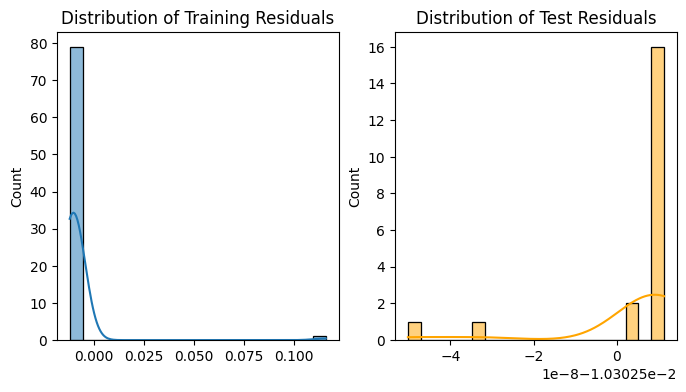

In [128]:
# Get predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Compute residuals
residuals_train = y_train - y_train_pred.flatten()
residuals_test = y_test - y_test_pred.flatten()

# Plot distribution of residuals
plt.figure(figsize=(8, 4))

plt.subplot(121)
sns.histplot(residuals_train, bins=20, kde=True)
plt.title('Distribution of Training Residuals')

plt.subplot(122)
sns.histplot(residuals_test, bins=20, kde=True, color='orange')
plt.title('Distribution of Test Residuals')

plt.show()


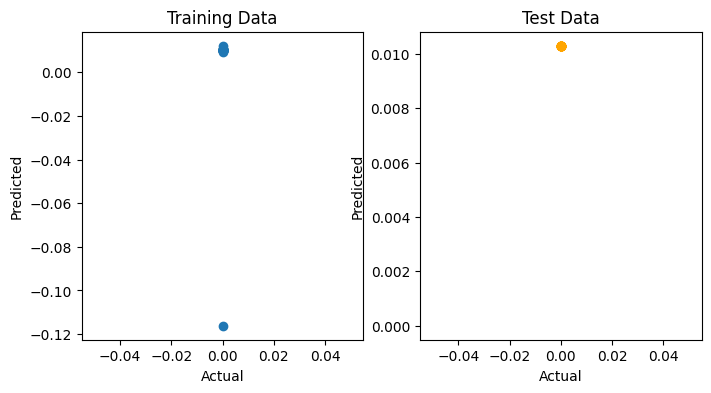

In [129]:
# Scatterplot of predicted vs. actual values
plt.figure(figsize=(8, 4))

plt.subplot(121)
plt.scatter(y_train, y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Training Data')

plt.subplot(122)
plt.scatter(y_test, y_test_pred, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Test Data')

plt.show()


In [130]:
from scipy import stats

# Test normality of residuals
_, p_value_train = stats.shapiro(residuals_train)
_, p_value_test = stats.shapiro(residuals_test)

print("Training residuals normality test p-value:", round(p_value_train, 4))
print("Test residuals normality test p-value:", round(p_value_test, 4))


Training residuals normality test p-value: 0.0
Test residuals normality test p-value: 0.0


In this case, a low p-value (typically below 0.05) indicates that the null hypothesis can be rejected, i.e., the residuals are not normally distributed.